# Modelo predictivo LSTM del indice Dow Jones
El Dow Jones Industrial Average (DJIA) es un índice que rastrea 30 grandes empresas públicas que cotizan en la Bolsa de Nueva York (NYSE) y el NASDAQ. La parte "industrial" del nombre es en gran parte histórica, ya que la mayoría de los 30 componentes modernos tienen poco o nada que ver con la industria pesada tradicional. Utiliza el índice de precio ponderado, lo que significa que las acciones con un precio de acción más alto tienen un mayor peso en el índice que las acciones con un precio de acción bajo.

En este notebook experimentaré con la red LSTM y los datos históricos desde el año 2014, e investigaré , con qué precisión es posible predecir el precio de cierre futuro. Para no complicar mucho la tarea ya que nos es el fin principal del proyecto TFM, no realizaré mucha ingeniería de características aquí, sino que relizará un pronóstico del índice de precios de cierre basado en apertura histórica, cierre, alto, bajo y volumen y algunos otros indicadores.

In [1]:
import keras
from keras.layers import Dropout
import pandas as pd
from keras.layers import Dense
from keras.layers import LSTM
import pandas_datareader.data as web
import numpy as np
import datetime
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Imports:
A continuación importo las siguintes librerías: 
* Keras para crear la red neuronal
* pandas y pandas_data reader para obtener y analizar el stock
* datetime para fijar las fechas de stock para el análisis de datos
* numpy para redimensionar los datos a alimentar en la red neuronal
* matplotlib para trazar y visualizar los datos

In [2]:
# Obtengo los datos de stock a través del API de yahoo:
style.use('ggplot')

# Extraigo los datos desde el  2014 al 2019 para entrenar el modelo
inicio = datetime.datetime(2014,12,31)
fin = datetime.datetime(2019,12,31)
train_df = web.DataReader("^DJI", 'yahoo', inicio, fin) 

# Extraigo los datos del 2020 para testear el modelo 
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2020,7,24)
#fin = datetime.date.today()
test_df = web.DataReader("^DJI", 'yahoo', start, end) 

In [3]:
test_df.to_csv('datosTESTDOWJONES.csv',encoding='utf-8')

In [4]:
train_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,18043.220703,17820.880859,17987.660156,17823.070312,82840000,17823.070312
2015-01-02,17951.779297,17731.300781,17823.070312,17832.990234,76270000,17832.990234
2015-01-05,17821.300781,17475.929688,17821.300781,17501.650391,116160000,17501.650391
2015-01-06,17581.050781,17262.369141,17504.179688,17371.640625,101870000,17371.640625
2015-01-07,17597.080078,17374.779297,17374.779297,17584.519531,91030000,17584.519531
...,...,...,...,...,...,...
2019-12-24,28576.800781,28503.210938,28572.570312,28515.449219,86150000,28515.449219
2019-12-26,28624.099609,28535.150391,28539.460938,28621.390625,155970000,28621.390625
2019-12-27,28701.660156,28608.980469,28675.339844,28645.259766,182280000,28645.259766


In [5]:
test_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,28872.800781,28627.769531,28638.970703,28868.800781,251820000,28868.800781
2020-01-03,28716.310547,28500.359375,28553.330078,28634.880859,239590000,28634.880859
2020-01-06,28708.019531,28418.630859,28465.500000,28703.380859,252760000,28703.380859
2020-01-07,28685.500000,28565.279297,28639.179688,28583.679688,258900000,28583.679688
2020-01-08,28866.179688,28522.509766,28556.140625,28745.089844,291750000,28745.089844
...,...,...,...,...,...,...
2020-07-20,26765.019531,26504.199219,26660.289062,26680.869141,309390000,26680.869141
2020-07-21,27025.380859,26766.220703,26833.140625,26840.400391,364930000,26840.400391
2020-07-22,27035.240234,26794.189453,26824.560547,27005.839844,404340000,27005.839844


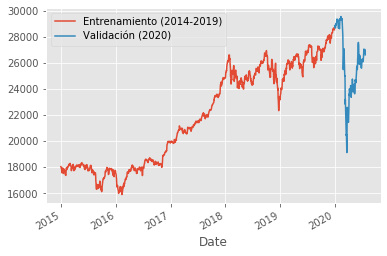

In [6]:
import matplotlib.pyplot as plt
train_df['High'].plot(legend=True)
test_df['High'].plot(legend=True)


plt.legend(['Entrenamiento (2014-2019)', 'Validación (2020)'])
plt.show()

## Obteniendo los datos de las acciones: 
* Este código cambia nuestro estilo de trazado a ggplot.   En el siguiente link existe más información sobre ggplot [aqui](https://matplotlib.org/3.1.1/gallery/style_sheets/ggplot.html). 
* Utilizo pandas_datareader como "web" para obtener los datos de los precios de las acciones utilizando la función DataReader que obtiene los datos financieros y los almacena en un dataframe.
* Obtengo los datos del índice DowJones desde el 2014 hasta el 2019 para el entrenamiento del modelo.
* Obtengo los datos del índice DowJones desde el año 2020 hasta la actualidad para testearlo.
* "^DJI" es el símbolo de cotización de las acciones para el índice Dow Jones y especifico 'yahoo' para obtener los datos utilizando la API de finanzas de Yahoo.

In [7]:
# ordeno por fecha
train_df = train_df.sort_values('Date')
test_df = test_df.sort_values('Date')

# corrigo la fecha 
train_df.reset_index(inplace=True)
train_df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

train_df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-24,28576.800781,28503.210938,28572.570312,28515.449219,86150000,28515.449219
2019-12-26,28624.099609,28535.150391,28539.460938,28621.390625,155970000,28621.390625
2019-12-27,28701.660156,28608.980469,28675.339844,28645.259766,182280000,28645.259766
2019-12-30,28664.689453,28428.980469,28654.759766,28462.140625,181600000,28462.140625
2019-12-31,28547.349609,28376.490234,28414.640625,28538.439453,193340000,28538.439453


## Nuevas features

Nuevas features para entrenar el modelo aplicadas a los datos de train

In [8]:
Aux=train_df.copy()
Aux['h_o'] = (Aux['High'] - Aux['Close'])/Aux['Close']  #porcentaje máximo de ganancia en el día respecto al cierre
Aux['pct_chng'] = (Aux['Close'] - Aux['Open'])/Aux['Open'] #porcentaje de variación diaria 
train_df = Aux[['High','Low','Open','Volume','Adj Close','h_o','pct_chng']]
#df = A[['Close','pct_chng']]
train_df.tail()

,High,Low,Open,Volume,Adj Close,h_o,pct_chng
Date,,,,,,,
2019-12-24,28576.800781,28503.210938,28572.570312,86150000,28515.449219,0.002152,-0.001999
2019-12-26,28624.099609,28535.150391,28539.460938,155970000,28621.390625,0.000095,0.002871
2019-12-27,28701.660156,28608.980469,28675.339844,182280000,28645.259766,0.001969,-0.001049
2019-12-30,28664.689453,28428.980469,28654.759766,181600000,28462.140625,0.007116,-0.006722
2019-12-31,28547.349609,28376.490234,28414.640625,193340000,28538.439453,0.000312,0.004357


# 1 Commodity Channel Index (CCI)

Índice de canal de productos básicos (CCI)


En el siguiente código, se utilizan las funciones Series, rollingmean, rollingstd y join para calcular el índice del canal de productos básicos. La función Serie se usa para formar una serie que es un objeto de matriz unidimensional que contiene una matriz de datos. La función rollingmean toma una serie temporal o un marco de datos junto con el número de períodos y calcula la media. La función rollingstd calcula la desviación estándar en función del precio proporcionado. La función de unión une una serie dada con una serie / marco de datos específico.



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

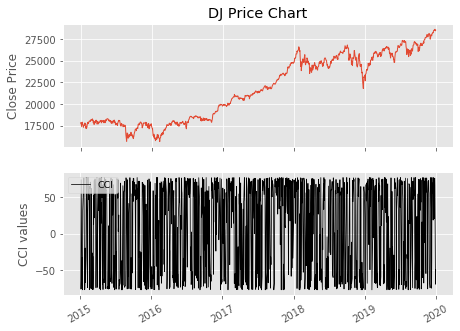

In [9]:
# Cargo los paquetes y módulos necesarios
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance
import pandas as pd

# Commodity Channel Index 
def CCI(data, ndays): 
    TP = (data['High'] + data['Low'] + data['Adj Close']) / 3 
    CCI = pd.Series((TP - TP.rolling(ndays).mean()) / (0.015 * TP.rolling(ndays).std()),
                    name = 'CCI') 
    data = data.join(CCI) 
    return data



# Calculo el Commodity Channel Index(CCI) para DJ basándome en la Moving average de 3 días
n = 3
DJ_CCI = CCI(train_df, n)
CCIAux = DJ_CCI['CCI']
train_df['CCI']=DJ_CCI['CCI']

# Plotting the Price Series chart and the Commodity Channel index below
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(2, 1, 1)
ax.set_xticklabels([])
plt.plot(train_df['Adj Close'],lw=1)
plt.title('DJ Price Chart')
plt.ylabel('Close Price')
plt.grid(True)
bx = fig.add_subplot(2, 1, 2)
plt.plot(CCIAux,'k',lw=0.75,linestyle='-',label='CCI')
plt.legend(loc=2,prop={'size':9.5})
plt.ylabel('CCI values')
plt.grid(True)
plt.setp(plt.gca().get_xticklabels(), rotation=30)

# 2 Ease of Movement (EVM)

EVM indica la facilidad con la que los precios suben o bajan teniendo en cuenta el volumen de la seguridad. 
En el siguiente código, Utilizo las funciones Series, rollingmean, shift y join para calcular el indicador de Facilidad de movimiento (EMV). La función Serie se usa para formar una serie que es un objeto de matriz unidimensional que contiene una matriz de datos. La función rollingmean toma una serie temporal o un marco de datos junto con el número de períodos y calcula la media. La función de desplazamiento se utiliza para obtener el precio máximo y mínimo del día anterior. La función de unión une una serie dada con una serie / marco de datos específico.



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

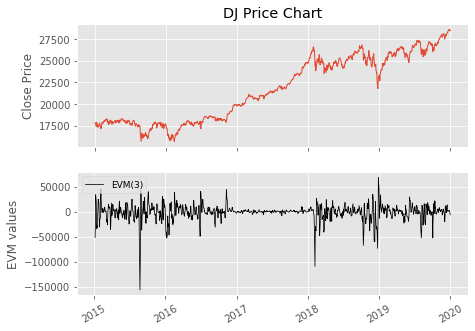

In [10]:
# Ease Of Movement (EVM) Code


 
# Ease of Movement 
def EVM(data, ndays): 
 dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
 br = (data['Volume'] / 100000000) / ((data['High'] - data['Low']))
 EVM = dm / br 
 EVM_MA = pd.Series(EVM.rolling(ndays).mean(), name = 'EVM') 
 data = data.join(EVM_MA) 
 return data 
 

# Calculo Ease of Movement for DJ en 3 días
n = 3
DJ_EVM = EVM(train_df, n)
EVMAux = DJ_EVM['EVM']
train_df['EVM']=DJ_EVM['EVM']


# Plotting the Price Series chart and the Ease Of Movement below
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(2, 1, 1)
ax.set_xticklabels([])
plt.plot(train_df['Adj Close'],lw=1)
plt.title('DJ Price Chart')
plt.ylabel('Close Price')
plt.grid(True)
bx = fig.add_subplot(2, 1, 2)
plt.plot(EVMAux,'k',lw=0.75,linestyle='-',label='EVM(3)')
plt.legend(loc=2,prop={'size':9})
plt.ylabel('EVM values')
plt.grid(True)
plt.setp(plt.gca().get_xticklabels(), rotation=30)

# 3 Moving Average (MA)

La media móvil es uno de los indicadores técnicos más utilizados. Se usa junto con otros indicadores técnicos o puede formar el bloque de construcción para el cálculo de otros indicadores técnicos.


En el siguiente código, utilizo las funciones Serie, media móvil y unión para crear las funciones SMA y EWMA. La función Serie se usa para formar una serie que es un objeto de matriz unidimensional que contiene una matriz de datos. La función rolling_mean toma una serie temporal o un marco de datos junto con el número de períodos y calcula la media. La función de unión une una serie dada con una serie / marco de datos específico.




[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

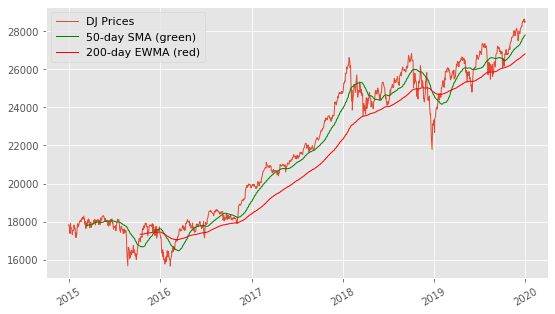

In [11]:
# Simple Moving Average 
def SMA(data, ndays): 
 SMA = pd.Series(train_df['Adj Close'].rolling(ndays).mean(), name = 'SMA') 
 data = data.join(SMA) 
 return data

# Exponentially-weighted Moving Average 
def EWMA(data, ndays): 
 EMA = pd.Series(data['Adj Close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
 data = data.join(EMA) 
 return data

close = train_df['Adj Close']

# calculo 50 días SMA para DJ
n = 50
SMA_DJ = SMA(train_df,n)
SMA_DJ = SMA_DJ.dropna()
SMAAux = SMA_DJ['SMA']
train_df['SMA']=SMA_DJ['SMA']


# calculo 200 días SMA para DJ
ew = 200
EWMA_DJ = EWMA(train_df,ew)
EWMA_DJ = EWMA_DJ.dropna()
EWMAAux = EWMA_DJ['EWMA_200']
train_df['EWMA']=EWMAAux



# Plotting the DowJones Price Series chart and Moving Averages below
plt.figure(figsize=(9,5))
plt.plot(train_df['Adj Close'],lw=1, label='DJ Prices')
plt.plot(SMAAux,'g',lw=1, label='50-day SMA (green)')
plt.plot(EWMAAux,'r', lw=1, label='200-day EWMA (red)')
plt.legend(loc=2,prop={'size':11})
plt.grid(True)
plt.setp(plt.gca().get_xticklabels(), rotation=30)

# 4 Rate of Change (ROC)

La tasa de cambio (ROC) es un indicador técnico que mide el cambio porcentual entre el precio más reciente y el precio "n" del día anterior. El indicador fluctúa alrededor de la línea cero.

En el siguiente código, utilizamos las funciones Series, diff, shift y join para calcular la Velocidad de cambio (ROC). La función Serie se usa para formar una serie que es un objeto de matriz unidimensional que contiene una matriz de datos. La función diff calcula la diferencia de precios entre el precio del día actual y el precio "n" del día anterior. La función de desplazamiento se utiliza para obtener el precio del día "n" anterior. La función de unión une una serie dada con una serie / marco de datos específico.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

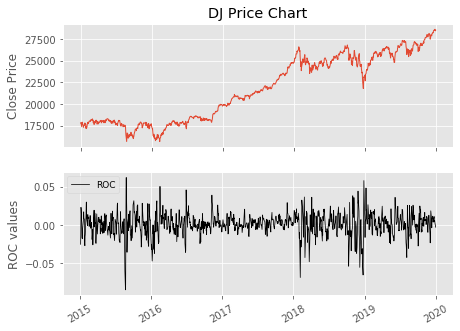

In [12]:
# Rate of Change (ROC)
def ROC(data,n):
 N = data['Adj Close'].diff(n)
 D = data['Adj Close'].shift(n)
 ROC = pd.Series(N/D,name='Rate of Change')
 data = data.join(ROC)
 return data 
 


# Selecciono un periodo de 3
n = 3
DJ_ROC = ROC(train_df,n)
ROCAux = DJ_ROC['Rate of Change']
train_df['ROC']=DJ_ROC['Rate of Change']

# Plotting the Price Series chart and the Ease Of Movement below
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(2, 1, 1)
ax.set_xticklabels([])
plt.plot(train_df['Adj Close'],lw=1)
plt.title('DJ Price Chart')
plt.ylabel('Close Price')
plt.grid(True)
bx = fig.add_subplot(2, 1, 2)
plt.plot(ROCAux,'k',lw=0.75,linestyle='-',label='ROC')
plt.legend(loc=2,prop={'size':9})
plt.ylabel('ROC values')
plt.grid(True)
plt.setp(plt.gca().get_xticklabels(), rotation=30)

# 5 Bollinger Bands

El concepto de las bandas de Bollinger fue desarrollado por John Bollinger. Estas bandas se componen de una banda superior de Bollinger y una banda inferior de Bollinger y se colocan dos desviaciones estándar por encima y por debajo de un promedio móvil.

En el siguiente código, ejecuto la función para crear la función de banda de Bollinger. La media y los métodos de desviación estándar se utilizan para calcular estas métricas respectivas utilizando el precio de cierre. Una vez que hemos calculado la media y la desviación estándar, calculamos la banda superior de Bollinger y la banda inferior de Bollinger. La función de banda de Bollinger se llama en los datos de precios del DJ utilizando la ventana de promedio móvil de 3 días.

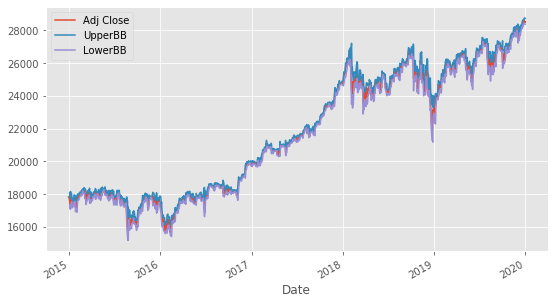

In [13]:
# Compute the Bollinger Bands 
def BBANDS(data, window=n):
    MA = data['Adj Close'].rolling(window=n).mean()
    SD =data['Adj Close'].rolling(window=n).std()
    data['UpperBB'] = MA + (2 * SD) 
    data['LowerBB'] = MA - (2 * SD)
    return data
 


# Calculo Bollinger Bands para DJ utilizando Moving average de 3 días
n = 3
DJ_BBANDS = BBANDS(train_df, n)
train_df['UpperBB']=DJ_BBANDS['UpperBB']
train_df['LowerBB']=DJ_BBANDS['LowerBB']


# Create the plot
pd.concat([DJ_BBANDS['Adj Close'],DJ_BBANDS.UpperBB,DJ_BBANDS.LowerBB],axis=1).plot(figsize=(9,5),grid=True)


# 6 Force Index

El índice de fuerza tiene en cuenta la dirección del precio de las acciones, la extensión del movimiento del precio de las acciones y el volumen. Usando estos tres elementos, forma un oscilador que mide la presión de compra y venta.

En el siguiente código, utilizamos las funciones Series, diff y join para calcular el índice de fuerza. La función Serie se usa para formar una serie que es un objeto de matriz unidimensional que contiene una matriz de datos. La función diff calcula la diferencia entre el punto de datos actual y el punto de datos "n" con períodos / días de diferencia. La función de unión une una serie dada con una serie / marco de datos específico.



In [14]:
# Force Index 
def ForceIndex(data, ndays): 
    FI = pd.Series(data['Adj Close'].diff(ndays) * data['Volume'], name = 'ForceIndex') 
    data = data.join(FI) 
    return data




# Calculo el Force Index para DJ
n = 3
DJ_ForceIndex = ForceIndex(train_df,n)
train_df['ForceIndex']=DJ_ForceIndex['ForceIndex']

print(DJ_ForceIndex)

                    High           Low          Open     Volume     Adj Close  \
Date                                                                            
2014-12-31  18043.220703  17820.880859  17987.660156   82840000  17823.070312   
2015-01-02  17951.779297  17731.300781  17823.070312   76270000  17832.990234   
2015-01-05  17821.300781  17475.929688  17821.300781  116160000  17501.650391   
2015-01-06  17581.050781  17262.369141  17504.179688  101870000  17371.640625   
2015-01-07  17597.080078  17374.779297  17374.779297   91030000  17584.519531   
...                  ...           ...           ...        ...           ...   
2019-12-24  28576.800781  28503.210938  28572.570312   86150000  28515.449219   
2019-12-26  28624.099609  28535.150391  28539.460938  155970000  28621.390625   
2019-12-27  28701.660156  28608.980469  28675.339844  182280000  28645.259766   
2019-12-30  28664.689453  28428.980469  28654.759766  181600000  28462.140625   
2019-12-31  28547.349609  28

In [15]:
train_df

,High,Low,Open,Volume,Adj Close,h_o,pct_chng,CCI,EVM,SMA,EWMA,ROC,UpperBB,LowerBB,ForceIndex
Date,,,,,,,,,,,,,,,
2014-12-31,18043.220703,17820.880859,17987.660156,82840000,17823.070312,0.012352,-0.009150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,17951.779297,17731.300781,17823.070312,76270000,17832.990234,0.006661,0.000557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,17821.300781,17475.929688,17821.300781,116160000,17501.650391,0.018264,-0.017936,-75.701131,NaN,NaN,NaN,NaN,18096.238538,17342.235420,NaN
2015-01-06,17581.050781,17262.369141,17504.179688,101870000,17371.640625,0.012055,-0.007572,-64.276144,-51502.923401,NaN,NaN,-0.025328,18044.527932,17092.992901,-4.598714e+10
2015-01-07,17597.080078,17374.779297,17374.779297,91030000,17584.519531,0.000714,0.012072,7.486926,-37553.803479,NaN,NaN,-0.013933,17700.548533,17271.325165,-2.261829e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28576.800781,28503.210938,28572.570312,86150000,28515.449219,0.002152,-0.001999,20.520221,1992.778893,27672.241094,26742.644691,0.004880,28604.808995,28409.903245,1.193077e+10
2019-12-26,28624.099609,28535.150391,28539.460938,155970000,28621.390625,0.000095,0.002871,76.076943,970.374535,27704.172891,26761.338746,0.005844,28670.511450,28455.067977,2.593793e+10
2019-12-27,28701.660156,28608.980469,28675.339844,182280000,28645.259766,0.001969,-0.001049,66.046735,2117.807425,27737.038477,26780.084293,0.003283,28732.221711,28455.844695,1.708519e+10


# Nuevas features para entrenar el modelo aplicadas a los datos de test

In [16]:
Aux=test_df.copy()
Aux['h_o'] = (Aux['High'] - Aux['Close'])/Aux['Close']  #porcentaje máximo de ganancia en el día respecto al cierre
Aux['pct_chng'] = (Aux['Close'] - Aux['Open'])/Aux['Open'] #porcentaje de variación diaria 
test_df = Aux[['High','Low','Open','Volume','Adj Close','h_o','pct_chng']]
#df = A[['Close','pct_chng']]
test_df.tail()

,High,Low,Open,Volume,Adj Close,h_o,pct_chng
Date,,,,,,,
2020-07-20,26765.019531,26504.199219,26660.289062,309390000,26680.869141,0.003154,0.000772
2020-07-21,27025.380859,26766.220703,26833.140625,364930000,26840.400391,0.006892,0.000271
2020-07-22,27035.240234,26794.189453,26824.560547,404340000,27005.839844,0.001089,0.006758
2020-07-23,26973.849609,26560.039062,26955.970703,419800000,26652.330078,0.012063,-0.011264
2020-07-24,26625.699219,26402.859375,26533.410156,494170000,26469.890625,0.005886,-0.002394


In [17]:
# Calculo el Commodity Channel Index(CCI) para DJ basándome en la Moving average de 3 días
n = 3
DJ_CCI_TEST = CCI(test_df, n)
CCI_TEST = DJ_CCI_TEST['CCI']
test_df['CCI']= CCI_TEST

# Calculo Ease of Movement for DJ en 3 días
n = 3
DJ_EVM = EVM(test_df, n)
EVM = DJ_EVM['EVM']
test_df['EVM']=EVM


# calculo 50 días SMA para DJ
n = 50
SMA_DJ = SMA(test_df,n)
SMA_DJ = SMA_DJ.dropna()
SMA = SMA_DJ['SMA']
test_df['SMA']=SMA


# calculo 200 días SMA para DJ
ew = 200
EWMA_DJ = EWMA(test_df,ew)
EWMA_DJ = EWMA_DJ.dropna()
EWMA = EWMA_DJ['EWMA_200']
test_df['EWMA']=EWMA

# Selecciono un periodo de 3
n = 3
DJ_ROC = ROC(test_df,n)
ROC = DJ_ROC['Rate of Change']
test_df['ROC']=ROC

# Calculo Bollinger Bands para DJ utilizando Moving average de 3 días
n = 3
DJ_BBANDS = BBANDS(test_df, n)
test_df['UpperBB']=DJ_BBANDS['UpperBB']
test_df['LowerBB']=DJ_BBANDS['LowerBB']

# Calculo el Force Index para DJ
n = 3
DJ_ForceIndex = ForceIndex(test_df,n)
test_df['ForceIndex']=DJ_ForceIndex['ForceIndex']


In [18]:
test_df

,High,Low,Open,Volume,Adj Close,h_o,pct_chng,CCI,EVM,SMA,EWMA,ROC,UpperBB,LowerBB,ForceIndex
Date,,,,,,,,,,,,,,,
2020-01-02,28872.800781,28627.769531,28638.970703,251820000,28868.800781,0.000139,0.008025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,28716.310547,28500.359375,28553.330078,239590000,28634.880859,0.002844,0.002856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,28708.019531,28418.630859,28465.500000,252760000,28703.380859,0.000162,0.008357,-40.815163,NaN,NaN,NaN,NaN,28976.207119,28495.167881,NaN
2020-01-07,28685.500000,28565.279297,28639.179688,258900000,28583.679688,0.003562,-0.001938,-24.764779,-5021.915689,NaN,NaN,-0.009876,28760.764246,28520.530024,-7.381785e+10
2020-01-08,28866.179688,28522.509766,28556.140625,291750000,28745.089844,0.004213,0.006617,76.973812,1950.458110,NaN,NaN,0.003849,28844.956828,28509.810100,3.215347e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20,26765.019531,26504.199219,26660.289062,309390000,26680.869141,0.003154,0.000772,-70.349313,-7610.177540,NaN,NaN,-0.007042,26763.752536,26627.933662,-5.854601e+10
2020-07-21,27025.380859,26766.220703,26833.140625,364930000,26840.400391,0.006892,0.000271,75.270806,3514.569312,NaN,NaN,0.003953,26920.643628,26541.502205,3.856925e+10
2020-07-22,27035.240234,26794.189453,26824.560547,404340000,27005.839844,0.001089,0.006758,52.167273,4323.538690,NaN,NaN,0.012518,27167.358397,26517.381186,1.350053e+11


## Preparando los datos:
*  Dado que estoy haciendo una predicción de series de tiempo, es necesario que los datos sean secuenciales. Clasifico los datos de entrenamiento y test por fecha. 
* Posteriormente reinicio el índice lo marco como el índice del dataframe

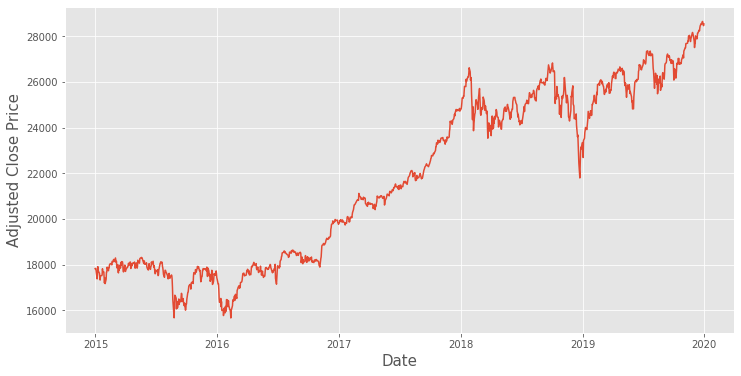

In [19]:
# Visualizo los datos de entrenamiento:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(train_df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()

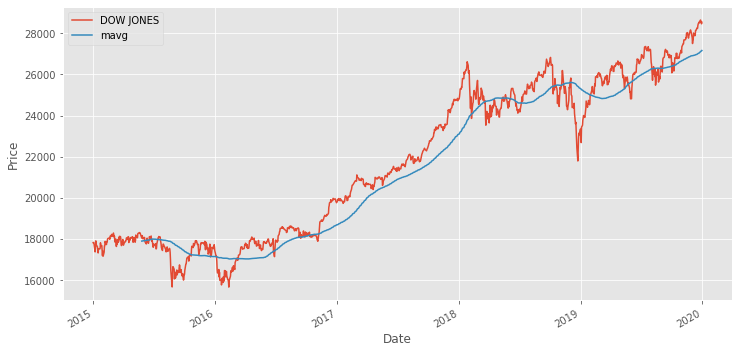

In [20]:
# Rolling mean
close_p = train_df['Adj Close']
mavg = close_p.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_p.plot(label='DOW JONES')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

## Rolling mean: 
* Obtengo los precios de cierre ajustados de nuestro dataframe y trazo una media móvil (Rolling mean)en nuestros datos.
* Rolling mean también es conocida como moving average o media móvil. El promedio móvil nos ayuda a suavizar los datos que tienen muchas fluctuaciones y nos ayuda a ver mejor la tendencia a largo plazo de los datos.
* Con el promedio móvil es posible definir un período de tiempo sobre el que tomar el promedio de lo que se conoce como nuestra ventana. En este caso la ventana definida es de 100. Defino 100 porque quiero ver el promedio móvil a largo plazo en los datos.

In [21]:
import matplotlib.dates as mdates

# Cambio las fechas a ints para el entrenamiento del modelo
dates_df = train_df.copy()
dates_df = dates_df.reset_index()

# Almaceno las fechas originales para posteriormente pintar las predicciones.
ini_dates = dates_df['Date']

# Conviento a ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df

,Date,High,Low,Open,Volume,Adj Close,h_o,pct_chng,CCI,EVM,SMA,EWMA,ROC,UpperBB,LowerBB,ForceIndex
0,735598.0,18043.220703,17820.880859,17987.660156,82840000,17823.070312,0.012352,-0.009150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,735600.0,17951.779297,17731.300781,17823.070312,76270000,17832.990234,0.006661,0.000557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,735603.0,17821.300781,17475.929688,17821.300781,116160000,17501.650391,0.018264,-0.017936,-75.701131,NaN,NaN,NaN,NaN,18096.238538,17342.235420,NaN
3,735604.0,17581.050781,17262.369141,17504.179688,101870000,17371.640625,0.012055,-0.007572,-64.276144,-51502.923401,NaN,NaN,-0.025328,18044.527932,17092.992901,-4.598714e+10
4,735605.0,17597.080078,17374.779297,17374.779297,91030000,17584.519531,0.000714,0.012072,7.486926,-37553.803479,NaN,NaN,-0.013933,17700.548533,17271.325165,-2.261829e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,737417.0,28576.800781,28503.210938,28572.570312,86150000,28515.449219,0.002152,-0.001999,20.520221,1992.778893,27672.241094,26742.644691,0.004880,28604.808995,28409.903245,1.193077e+10
1255,737419.0,28624.099609,28535.150391,28539.460938,155970000,28621.390625,0.000095,0.002871,76.076943,970.374535,27704.172891,26761.338746,0.005844,28670.511450,28455.067977,2.593793e+10
1256,737420.0,28701.660156,28608.980469,28675.339844,182280000,28645.259766,0.001969,-0.001049,66.046735,2117.807425,27737.038477,26780.084293,0.003283,28732.221711,28455.844695,1.708519e+10
1257,737423.0,28664.689453,28428.980469,28654.759766,181600000,28462.140625,0.007116,-0.006722,-69.243026,-2657.586668,27765.763672,26796.821230,-0.001869,28775.366523,28377.160821,-9.680841e+09


In [22]:
dates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1259 non-null   float64
 1   High        1259 non-null   float64
 2   Low         1259 non-null   float64
 3   Open        1259 non-null   float64
 4   Volume      1259 non-null   int64  
 5   Adj Close   1259 non-null   float64
 6   h_o         1259 non-null   float64
 7   pct_chng    1259 non-null   float64
 8   CCI         1257 non-null   float64
 9   EVM         1256 non-null   float64
 10  SMA         1210 non-null   float64
 11  EWMA        1061 non-null   float64
 12  ROC         1256 non-null   float64
 13  UpperBB     1257 non-null   float64
 14  LowerBB     1257 non-null   float64
 15  ForceIndex  1256 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 157.5 KB


In [23]:
dates_df.dropna(inplace=True)

## Convirtienfo las fechas: 
* Creo una copia del dataframe y lo llamo date_df. Almaceno las fechas originales en ini_dates. Posteriomente utilizaré ini_dates para trazar las predicciones y fechas.
* A continuación transformo las fechas date_df a números enteros usando mdates.date2num. Es necesario transformar las fechas a números enteros para poder entrenar la red neuronales.

In [24]:
# Extraigo los datos de entrenamiento de Adj Close
train_data = train_df.loc[:,'Adj Close'].to_numpy()
#train_data = train_df.loc[:,'h_o'].to_numpy()
print(train_data.shape) # 1258 

(1259,)


In [25]:
train_data

array([17823.0703125 , 17832.99023438, 17501.65039062, ...,
       28645.25976562, 28462.140625  , 28538.43945312])

In [26]:
# Normalizo los datos antes de alimentar la red LSTM:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

## Normalizando: 
* Aquí creo los datos de entrenamiento y los normalizo. Utilizo sklearn para crear un objeto MinMaxScaler ().
* MinMaxScaler funciona reduciendo el rango de los valores a un valor entre 0 y 1
* A continuación se presento la ecuación para el escalador min-max:
<img src="Images/MinMax.png">
* Esta es la ecuación que sklearn está haciendo en segundo plano para convertir nuestros datos en el rango deseado. 

In [27]:
'''Función que crea un dataset para ser alimentado en una red LSTM'''
def crear_LSTM_dataset(dataset, rango):
    dataX, dataY = [], []
    for i in range(len(dataset)-rango):
        a = dataset[i:(i + rango), 0]
        dataX.append(a)
        dataY.append(dataset[i + rango, 0])
    return np.array(dataX), np.array(dataY)

In [28]:
# Genero los datos de entrenamiento para el entrenamiento del modelo:
time_steps = 3
X_train, y_train = crear_LSTM_dataset(train_data, time_steps)

# Lo redimensiono [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 3, 1))

print(X_train.shape)

(1256, 3, 1)


In [29]:
# Visualizo los datos: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

X_train:
[[17823.0703125 ]
 [17832.99023438]
 [17501.65039062]]


y_train: [[17371.640625]]



## Preparando los datos para la red neuronal: 
* Aquí he creado la función 'crear_LSTM_dataset'. Esta función realiza un bucle desde (0 hasta la longitud de nuestro conjunto de datos: el número de time steps). 
* Cada índice en la matriz X_train contiene una matriz de 3 días de precios de cierre y la matriz y_train contiene el precio de cierre un día después de nuestros time steps.
* Es decir se alimenta la red neuronal con los precios de cierre de los 3 días previos y la red debe ser capaz de realizar la predicción del precio de cierre de las acciones del día inmediatamente posterior.

In [31]:
# Construyo el modelo 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(units = 1))

# Compilando el modelo
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Ajustando el modelo al conjunto de entrenamiento
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Train on 879 samples, validate on 377 samples
Epoch 1/20
879/879 [==============================] - 1s 925us/step - loss: 0.0150 - val_loss: 7.6393e-04
Epoch 2/20
879/879 [==============================] - 0s 276us/step - loss: 0.0012 - val_loss: 8.0256e-04
Epoch 3/20
879/879 [==============================] - 0s 303us/step - loss: 0.0011 - val_loss: 6.7808e-04
Epoch 4/20
879/879 [==============================] - 0s 289us/step - loss: 0.0013 - val_loss: 7.7844e-04
Epoch 5/20
879/879 [==============================] - 0s 284us/step - loss: 0.0011 - val_loss: 0.0023
Epoch 6/20
879/879 [==============================] - 0s 313us/step - loss: 9.4348e-04 - val_loss: 8.2784e-04
Epoch 7/20
879/879 [==============================] - 0s 281us/step - loss: 0.0010 - val_loss: 6.4434e-04
Epoch 8/20
879/879 [==============================] - 0s 301us/step - loss: 9.5563e-04 - val_loss: 6.3630e-04
Epoch 9/20
879/879 [==============================] - 0s 288us/step - loss: 9.0497e-04 - val_loss: 0.0

### Dropout:
* Es una técnica de regularización utilizada en el aprendizaje profundo y las redes neuronales.
* La regularización es una técnica utilizada para ayudar a las redes a no sobreajustar nuestros datos.
* El sobreajuste se produce cuando nuestra red neuronal funciona bien en nuestros datos de entrenamiento pero muy mal en nuestros datos de prueba. Esto significa que la red no generaliza bien, lo que significa que clasifica nuevas imágenes que no ha visto antes de forma incorrecta / deficiente
* Básicamente se desactivan algunas neuronas en una capa para que no aprendan ninguna información durante las actualizaciones (retropropagación) de los pesos de la red. Esto permite que otras neuronas activas aprendan mejor y reduzcan el error.


### El código:

Secuencial: aquí Construyo la red neuronal. Creo el modelo como secuencial. Secuencial significa que puede crear un modelo capa por capa. Secuencial significa que hay una sola entrada y una única salida, casi como una tubería.
Capas LSTM: Defino dos capas LSTM con un dropout del 20% después de cada capa.
La primera capa defino return_sequences = true. Hago esto porque he apilado capas LSTM y quiero que la segunda capa LSTM tenga una entrada de secuencia tridimensional.
También defino input_shape que lo he configurado como el x.shape para asegurarme de que tenga la misma forma 3D de los datos.
Capa de salida: Un nodo que retorna un número entre 0 y 1.
Compilación: Compilo el modelo. Utilizo el optimizador Adam, que es un tipo de algoritmo de optimización de descenso de gradiente y defino la función de pérdida como el error cuadrático medio. Utilizo Adam para minimizar la función de coste del error cuadrático medio.
Ajuste del modelo: por último, ajusto el modelo utilizando la retropropagación y nuestro optimizador Adam. Defino 20 épocas y un tamaño de lote de 10. También utilizamos la función de división Keras incorporada para dividir nuestros datos en un 70% de entrenamiento y un 30% de prueba.

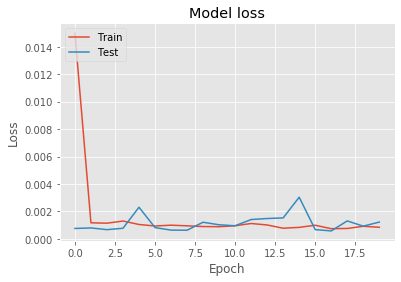

In [32]:
# Visualización de los valores de  training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Dibujando la loss: 
* Aquí utilizo el código de [keras api](https://keras.io/visualization/)para trazar la pérdida del modelo. A medida que se alcanza a la vigésima época, la pérdida de la prueba y la pérdida del tren están muy cerca y se minimizan.

In [33]:
# Obtengo los precios de cierre para 2020 para hacer la predicción
test_data = test_df['Adj Close'].values
#test_data = test_df['h_o'].values
test_data = test_data.reshape(-1,1)
test_data_scaled = scaler.transform(test_data)

# Creo lso datos de test del modelo:
time_steps = 3
X_test, y_test = crear_LSTM_dataset(test_data_scaled, time_steps)

# Almaceno los valores originales
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# Los redimensiono [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0],3, 1))

# Realizo la predicción de los precios con el modelo
predicted_y = model.predict(X_test)
predicted_y_transform = scaler.inverse_transform(predicted_y)

In [34]:
#Prediccion realizada por el modelo

In [35]:
test_df.iloc[3:,:]

,High,Low,Open,Volume,Adj Close,h_o,pct_chng,CCI,EVM,SMA,EWMA,ROC,UpperBB,LowerBB,ForceIndex
Date,,,,,,,,,,,,,,,
2020-01-07,28685.500000,28565.279297,28639.179688,258900000,28583.679688,0.003562,-0.001938,-24.764779,-5021.915689,NaN,NaN,-0.009876,28760.764246,28520.530024,-7.381785e+10
2020-01-08,28866.179688,28522.509766,28556.140625,291750000,28745.089844,0.004213,0.006617,76.973812,1950.458110,NaN,NaN,0.003849,28844.956828,28509.810100,3.215347e+10
2020-01-09,28988.009766,28844.310547,28851.970703,275060000,28956.900391,0.001074,0.003637,73.275614,7530.960741,NaN,NaN,0.008832,29136.243318,28387.536630,6.973308e+10
2020-01-10,29009.070312,28789.099609,28977.519531,237830000,28823.769531,0.006429,-0.005306,20.937990,6043.870121,NaN,NaN,0.008400,29056.050765,28627.789079,5.710057e+10
2020-01-13,28909.910156,28819.429688,28869.009766,249830000,28907.050781,0.000099,0.001318,-33.175950,2920.857569,NaN,NaN,0.005634,29030.429702,28761.384100,4.046270e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20,26765.019531,26504.199219,26660.289062,309390000,26680.869141,0.003154,0.000772,-70.349313,-7610.177540,NaN,NaN,-0.007042,26763.752536,26627.933662,-5.854601e+10
2020-07-21,27025.380859,26766.220703,26833.140625,364930000,26840.400391,0.006892,0.000271,75.270806,3514.569312,NaN,NaN,0.003953,26920.643628,26541.502205,3.856925e+10
2020-07-22,27035.240234,26794.189453,26824.560547,404340000,27005.839844,0.001089,0.006758,52.167273,4323.538690,NaN,NaN,0.012518,27167.358397,26517.381186,1.350053e+11


In [36]:
org_y

array([[28583.6796875 ],
       [28745.08984375],
       [28956.90039062],
       [28823.76953125],
       [28907.05078125],
       [28939.66992188],
       [29030.22070312],
       [29297.640625  ],
       [29348.09960937],
       [29196.0390625 ],
       [29186.26953125],
       [29160.08984375],
       [28989.73046875],
       [28535.80078125],
       [28722.84960937],
       [28734.44921875],
       [28859.43945312],
       [28256.02929688],
       [28399.81054688],
       [28807.63085938],
       [29290.84960938],
       [29379.76953125],
       [29102.50976563],
       [29276.8203125 ],
       [29276.33984375],
       [29551.41992188],
       [29423.31054688],
       [29398.08007813],
       [29232.18945312],
       [29348.02929688],
       [29219.98046875],
       [28992.41015625],
       [27960.80078125],
       [27081.359375  ],
       [26957.58984375],
       [25766.640625  ],
       [25409.359375  ],
       [26703.3203125 ],
       [25917.41015625],
       [27090.859375  ],


In [37]:
predicted_y_transform

array([[28242.133],
       [28148.672],
       [28167.615],
       [28211.326],
       [28318.68 ],
       [28375.625],
       [28355.533],
       [28415.875],
       [28507.477],
       [28638.04 ],
       [28731.445],
       [28701.105],
       [28633.139],
       [28589.33 ],
       [28440.27 ],
       [28262.062],
       [28143.588],
       [28245.121],
       [28177.352],
       [28060.01 ],
       [27941.48 ],
       [28220.516],
       [28553.762],
       [28721.535],
       [28700.572],
       [28646.639],
       [28766.184],
       [28829.791],
       [28892.564],
       [28803.523],
       [28762.254],
       [28710.053],
       [28672.793],
       [28357.99 ],
       [27771.477],
       [27046.361],
       [26420.998],
       [25908.541],
       [25543.97 ],
       [25675.488],
       [26174.732],
       [26053.623],
       [26167.758],
       [25295.594],
       [24739.018],
       [23998.312],
       [23542.158],
       [22499.586],
       [21575.256],
       [21612.203],


In [38]:
def ComparaValor(dataset):
    result=[]
    
    i=0
    for i in range(len(dataset)-1):
        x = dataset[i]
        y = dataset[i+1]
        if x>y:
            result.append(0)
        elif x<y:
            result.append(1)
       
    return result

In [39]:
resultadoTest=ComparaValor(predicted_y_transform)
resultadoReal=ComparaValor(org_y)

               

In [40]:
def calculoAcierto(datasetTest,datasetTrain):
    c = np.equal(datasetTest,datasetTrain)
    contUnos=0
    contCeros=0
    for i in range(len(c)):

        if (c[i]==True):
            c[i]=1
            contUnos=contUnos+1
        else:
            c[i]=0
            contCeros=contCeros+1
    porcentaje=(contUnos/(contUnos+contCeros))*100
    return porcentaje,contUnos,contCeros

In [41]:
pAcierto,aciertos,fallos=calculoAcierto(resultadoTest,resultadoReal)

In [42]:
aciertos

59

In [43]:
fallos

79

In [44]:
pAcierto

42.7536231884058

In [50]:
import plotly.graph_objects as go
labels=["aciertos", "fallos"]
values = [pAcierto, 100-pAcierto]
colors = ['lightgreen', 'darkorange',]


# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

In [51]:
#valores reales de Y

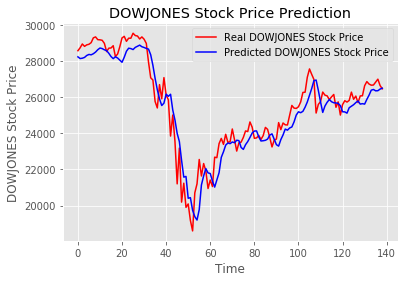

In [52]:
plt.plot(org_y, color = 'red', label = 'Real DOWJONES Stock Price')
plt.plot(predicted_y_transform, color = 'blue', label = 'Predicted DOWJONES Stock Price')
plt.title('DOWJONES Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('DOWJONES Stock Price')
plt.legend()
plt.show()

## Realizando la predicción: 
* Aquí tenemos nuestra red neuronal para hacer predicciones sobre los datos de stock de del índice Dow Jones no vistos por la red en el año 2020.
* Primero obtengo los datos de precios de cierre de acciones de 2020 del dataframe de prueba y los transformo en valores entre 0 y 1.
* Utilizo mi función crear_LSTM_dataset nuevamente para convertir los datos de test en lotes de 3 precios de acciones. 
* Almaceno los valores y originales en una variable org_y. 
* Por último, La red realiza las predicciones de precios.
* Como puede observarse en el gráfico de predicción anterior, el modelo funcionó bastante bien y siguió el comportamiento durante todo el año de datos no vistos.



In [53]:
# Calculate the error with MSE
real_mse = np.mean(np.square(org_y - predicted_y_transform))
scaled_mse = real_mse / (np.max(org_y) - np.min(org_y)) * 100

print('scaled_mse = ' + str(scaled_mse))

scaled_mse = 6556.787133016448


## Accuracy score

In [54]:
mean_org_y = org_y.mean()
mean_predicted_y = predicted_y_transform.mean()
print(mean_org_y,mean_predicted_y)

25585.438371178057 25309.742


In [55]:
accuracy = (mean_org_y / mean_predicted_y)*100
accuracy

101.0892887870435

In [56]:
accuracy = (org_y / predicted_y_transform)*100
accuracy

array([[101.20935227],
       [102.11881389],
       [102.80210145],
       [102.17091304],
       [102.07767841],
       [101.98777973],
       [102.37938569],
       [103.10307399],
       [102.94878098],
       [101.94845743],
       [101.58301893],
       [101.5991871 ],
       [101.24538145],
       [ 99.81276477],
       [100.99359142],
       [101.67145168],
       [102.54356895],
       [100.03861978],
       [100.78949572],
       [102.66436505],
       [104.82926859],
       [104.10784098],
       [101.92180649],
       [101.9333408 ],
       [102.00611881],
       [103.1584203 ],
       [102.28437308],
       [101.9711869 ],
       [101.17547544],
       [101.89041407],
       [101.59141409],
       [100.98347929],
       [ 97.516837  ],
       [ 95.49816172],
       [ 97.06934301],
       [ 95.26841823],
       [ 96.17108078],
       [103.06763432],
       [101.46194755],
       [105.51253818],
       [ 99.79578349],
       [ 99.27517279],
       [ 91.14659231],
       [ 98

In [57]:
for i in range(len(predicted_y)):
    print('iteration=%d, Predicted=%f, Expected=%f' % (i+1,   predicted_y_transform[i], org_y[i]))

iteration=1, Predicted=28242.132812, Expected=28583.679688
iteration=2, Predicted=28148.671875, Expected=28745.089844
iteration=3, Predicted=28167.615234, Expected=28956.900391
iteration=4, Predicted=28211.326172, Expected=28823.769531
iteration=5, Predicted=28318.679688, Expected=28907.050781
iteration=6, Predicted=28375.625000, Expected=28939.669922
iteration=7, Predicted=28355.533203, Expected=29030.220703
iteration=8, Predicted=28415.875000, Expected=29297.640625
iteration=9, Predicted=28507.476562, Expected=29348.099609
iteration=10, Predicted=28638.039062, Expected=29196.039062
iteration=11, Predicted=28731.445312, Expected=29186.269531
iteration=12, Predicted=28701.105469, Expected=29160.089844
iteration=13, Predicted=28633.138672, Expected=28989.730469
iteration=14, Predicted=28589.330078, Expected=28535.800781
iteration=15, Predicted=28440.269531, Expected=28722.849609
iteration=16, Predicted=28262.062500, Expected=28734.449219
iteration=17, Predicted=28143.587891, Expected=28